<a href="https://colab.research.google.com/github/alstonlo/xelfies/blob/dev/time_selfies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [ ]:
!sudo apt-get -qq install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

In [ ]:
!pip install -qq selfies==2.1.1 pandas rdkit matplotlib SciencePlots

In [ ]:
%config InlineBackend.figure_formats = ['svg']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random
import selfies as sf 
import timeit

from rdkit import Chem

plt.style.use("science")

# SELFIES Translation

In [ ]:
def time_roundtrip_translation(smiles):
    selfies = [sf.encoder(s) for s in smiles]

    def batch_encode():
        for s in smiles: 
            sf.encoder(s)

    def batch_decode():
        for s in selfies:
            sf.decoder(s)

    n_trials = 3
    encode_time = timeit.timeit(stmt=batch_encode, number=n_trials) / n_trials
    decode_time = timeit.timeit(stmt=batch_decode, number=n_trials) / n_trials 
    return encode_time, decode_time

In [ ]:
def time_individual_roundtrip_translation(smiles):
    sizes = []
    times = []
    for s in smiles:
        n_trials = 3
        time = timeit.timeit(stmt=lambda: sf.decoder(sf.encoder(s)), number=n_trials) / n_trials
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            sizes.append(mol.GetNumAtoms())
            times.append(time)
    return sizes, times

def plot_translation_sizes_vs_time(sizes, times):
    times = np.array(times) * 1000
    plt.scatter(sizes, times, s=2)
    plt.xlabel("Number of Atoms")
    plt.ylabel("Roundtrip Time (ms)")
    plt.xlim((0, 60))
    plt.tight_layout()

    plt.savefig("nci_open_compound_translation.pdf")
    plt.show()

## NCI Open Compound

In [ ]:
nci_open_compound = pd.read_csv("PubChem_compound_text_DTP_NCI.csv")
nci_open_compound = nci_open_compound["isosmiles"].tolist()

# csv file saves backslashes as \\, so we replace
nci_open_compound = [s.replace("\\\\", "\\") for s in nci_open_compound]

len(nci_open_compound)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


301607

In [ ]:
constraints = sf.get_preset_constraints(name="hypervalent")
constraints["P-1"] = 6
sf.set_semantic_constraints(constraints)

In [ ]:
encode_time, decode_time = time_roundtrip_translation(nci_open_compound)

print("Encode time:", encode_time)
print("Decode time:", decode_time)
print("Total time: ", encode_time + decode_time)

Encode time: 136.29431584966673
Decode time: 116.39895675733351
Total time:  252.69327260700024


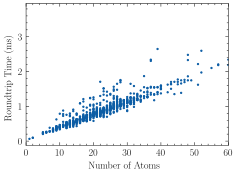

In [ ]:
random.seed(100)
subset = random.sample(nci_open_compound, k=1000)

sizes, times = time_individual_roundtrip_translation(subset)
plot_translation_sizes_vs_time(sizes, times)

# SELFIES Randomization

In [ ]:
sf.set_semantic_constraints()  # reset to defaults
random.seed(100)

In [ ]:
def time_random_selfies(n, length):
    rand_selfies = ["".join(random.choices(alphabet, k=length)) for _ in range(n)]

    def batch_decode():
        for s in rand_selfies:
            sf.decoder(s)

    n_trials = 20
    decode_time = timeit.timeit(stmt=batch_decode, number=n_trials) / n_trials 

    sizes = [Chem.MolFromSmiles(sf.decoder(s)).GetNumAtoms() for s in rand_selfies]
    return decode_time, sizes

def plot_smiles_size_distribution(ax, sizes_log):
    bins = list(range(0, 251, 10))
    for l, sizes in sizes_log.items():
        ax.hist(sizes, bins=bins, density=True, label=str(l), alpha=0.5, zorder=(250 - l))
    ax.set_xlabel("Number of Atoms")
    ax.set_ylabel("Normalized Counts")
    ax.set_yscale("log")
    ax.legend(title="Symbol Length")

## Standard Alphabet

In [ ]:
alphabet = list(sf.get_semantic_robust_alphabet())
print(alphabet)
len(alphabet)

['[=Ring3]', '[=P]', '[P-1]', '[O-1]', '[Br]', '[P]', '[#P-1]', '[=B]', '[#O+1]', '[=N+1]', '[=C]', '[C-1]', '[S-1]', '[=S+1]', '[B]', '[H]', '[=P-1]', '[#S+1]', '[=O]', '[O]', '[Ring1]', '[#N+1]', '[#S-1]', '[N+1]', '[Branch1]', '[#Branch2]', '[O+1]', '[#S]', '[=Branch1]', '[=N]', '[=Branch2]', '[=C+1]', '[B+1]', '[P+1]', '[=B-1]', '[Branch2]', '[=S]', '[Ring3]', '[S+1]', '[S]', '[Ring2]', '[N]', '[#N]', '[C]', '[#B]', '[=Ring2]', '[#C]', '[#Branch1]', '[=O+1]', '[Branch3]', '[B-1]', '[#B-1]', '[#C+1]', '[=P+1]', '[C+1]', '[Cl]', '[#Branch3]', '[#P]', '[I]', '[=N-1]', '[N-1]', '[=Ring1]', '[#C-1]', '[=Branch3]', '[#P+1]', '[=S-1]', '[=C-1]', '[F]', '[=B+1]']


69

In [ ]:
lengths = [10, 100, 250]
sizes_log_stnd = dict()

for l in lengths:
    decode_time, sizes_log_stnd[l] = time_random_selfies(n=1000, length=l)
    print(f"Decode time (length={l:4}):", decode_time)

Decode time (length=  10): 0.08223833985002785
Decode time (length= 100): 0.1988577752499623
Decode time (length= 250): 0.34106298934998447


## Filtered Alphabet

In [ ]:
def f(symbol): 
    return all((s not in symbol) for s in ("=", "#", "[F]", "[Cl]", "[Br]", "[I]", "[H]", "[O-1]", "Branch", "Ring"))

alphabet = list(filter(f, sf.get_semantic_robust_alphabet()))
alphabet.extend(["[Branch1]", "[Ring1]"])
print(alphabet)
len(alphabet)

['[P-1]', '[P]', '[C-1]', '[S-1]', '[B]', '[O]', '[N+1]', '[O+1]', '[B+1]', '[P+1]', '[S+1]', '[S]', '[N]', '[C]', '[B-1]', '[C+1]', '[N-1]', '[Branch1]', '[Ring1]']


19

In [ ]:
lengths = [10, 100, 250]
sizes_log_filt = dict()

for l in lengths:
    decode_time, sizes_log_filt[l] = time_random_selfies(n=1000, length=l)
    print(f"Decode time (length={l:4}):", decode_time)

Decode time (length=  10): 0.13307460139999422
Decode time (length= 100): 0.929271802400035
Decode time (length= 250): 1.6330489501500325


## Plotting

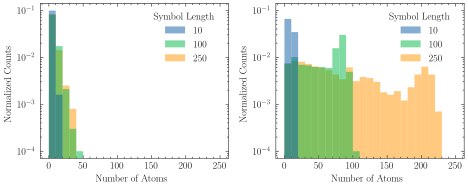

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6.7, 2.8))

plot_smiles_size_distribution(axes[0], sizes_log_stnd)
plot_smiles_size_distribution(axes[1], sizes_log_filt)

axes[1].yaxis.set_tick_params(labelbottom=True)

plt.tight_layout()

plt.savefig("n=1000_length=50_size_hist.pdf")
plt.show()